# Visualize and analyze differential expression data in a network

In analysis of differential expression data, it is often useful to analyze properties of the local neighborhood of specific genes.  I developed a simple interactive tool for this purpose, which takes as input diferential expression data, and gene interaction data (from http://www.genemania.org/). The network is then plotted in an interactive widget, where the node properties, edge properties, and layout can be mapped to different network properties.  The interaction type (of the 6 options from genemania) can also be selected.    

This tool will also serve as an example for how to create, modify, visualize and analyze weighted and unweighted gene interaction networks using the highly useful and flexible python package NetworkX (https://networkx.github.io/)

This tool is most useful if you have a reasonably small list of genes (~100) with differential expression data, and want to explore properties of their interconnections and their local neighborhoods.

In [8]:
# import some useful packages

import numpy as np
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt

% matplotlib inline

### Import a real network (from this experiment http://www.ncbi.nlm.nih.gov/sites/GDSbrowser?acc=GDS4419)

This experiment contains fold change information for genes in an experiment studying 'alveolar macrophage response to bacterial endotoxin lipopolysaccharide exposure in vivo'.  We selected a list of genes from the experiment which had high differential expression, and were enriched for 'immune response' and 'response to external biotic stimulus' in the gene ontology.  This experiment and gene list were selected purely as examples for how to use this tool for an initial exploration of differential expression data.  

NOTE: change paths/filenames in this cell to apply network visualizer to other datasets.  Network format comes from genemania (e.g. columns are 'Entity 1', 'Entity 2', 'Weight', 'Network_group', 'Networks')

NOTE: File format is tsv, and needs to contain columns for 'IDENTIFIER', 'DiffExp', and 'absDiffExp'.  Other columns are optional

In [9]:
dataDE = pd.read_csv('DE_data/example_DE_data.tsv',sep='\t')
print(dataDE.head())

# genes in dataDE
gene_list = list(dataDE['IDENTIFIER'])

# only use the average fold-change (because there are multiple entries for some genes
dataDE_mean = dataDE.DiffExp.groupby(dataDE['IDENTIFIER']).mean()

# load the gene-gene interactions (from genemania)
filename = 'DE_data/DE_experiment_interactions.txt'

DE_network = pd.read_csv(filename, sep='\t', header=6)
DE_network.columns = ['Entity 1','Entity 2', 'Weight','Network_group','Networks']

   Unnamed: 0       ID_REF IDENTIFIER  GSM1004102  GSM1004104  GSM1004106  \
0       14086    204639_at        ADA       301.4       210.5       602.4   
1       12361    202912_at        ADM       365.4       814.5      1234.2   
2       20248  210873_x_at   APOBEC3A       394.7      1358.8      2685.7   
3       16078  206632_s_at   APOBEC3B       440.5        26.1        55.7   
4       29826  220542_s_at     BPIFA1       562.3       110.0        52.7   

   GSM1004108  GSM1004110  GSM1004112  GSM1004114  GSM1004101  GSM1004103  \
0       226.9       231.5       279.0       414.2        46.1        34.3   
1       618.6      1008.6       727.5      1013.0        80.5        40.3   
2      1206.8       816.2      1282.7      1084.0        52.9        47.8   
3        27.4       487.7        38.9       497.5        26.2        19.1   
4       107.3       211.5        94.4        44.7       115.9        77.4   

   GSM1004105  GSM1004107  GSM1004109  GSM1004111  GSM1004113   DiffExp  \

In [10]:
# create the graph, and add some edges (and nodes)
G_DE = nx.Graph()
idxCE = DE_network['Network_group']=='Co-expression'
edge_list = zip(list(DE_network['Entity 1'][idxCE]),list(DE_network['Entity 2'][idxCE]))
G_DE.add_edges_from(edge_list)

print('number of edges = ' + str(len(G_DE.edges())))
print('number of nodes = '+ str(len(G_DE.nodes())))


number of edges = 940
number of nodes = 74


In [11]:
# create version with weighted edges
G_DE_w = nx.Graph()
edge_list_w = zip(list(DE_network['Entity 1']),list(DE_network['Entity 2']),list(DE_network['Weight']))
    
G_DE_w.add_weighted_edges_from(edge_list_w)

## Import plotting tool

(and reload it if changes have been made)

In [22]:
import imp
import plot_network
imp.reload(plot_network)

<module 'plot_network' from 'plot_network.py'>

# Run the plotting tool on prepared data

### Description of options:
- **focal_node_name**: Select gene to focus on (a star will be drawn on this node)
- **edge_threshold**: Change the number of edges included in the network by moving the edge_threshold slider.  Higher values of edge_threshold means fewer edges will be included in the graph (and may improve interpretability).  The threshold is applied to the 'Weight' column of DE_network, so the less strongly weighted edges are not included as the threshold increases
- **network_algo**:  Select the network algorithm to apply to the graph.  Choices are:
    - 'spl' (shortest path length): Plot the network in a circular tree layout, with the focal gene at the center, with nodes color-coded by log fold-change.
    - 'clustering coefficient': Plot the network in a circular tree layout, with nodes color-coded by the local clustering coefficient (see https://en.wikipedia.org/wiki/Clustering_coefficient).
    - 'pagerank':  Plot the network in a spring layout, with nodes color-coded by page rank score (see https://en.wikipedia.org/wiki/PageRank for algorithm description)
    - 'community':  Group the nodes in the network into communities, using the Louvain modularity maximization algorithm, which finds groups of nodes optimizing for modularity (a metric which measures the number of edges within communities compared to number of edges between communities, see https://en.wikipedia.org/wiki/Modularity_(networks) for more information).  The nodes are then color-coded by these communities, and the total modularity of the partition is printed above the graph (where the maximal value for modularity is 1 which indicates a perfectly modular network so that there are no edges connecting communities).  Below the network the average fold-change in each community is shown with box-plots, where the focal node's community is indicated by a white star, and the colors of the boxes correspond to the colors of the communities above.
- **map_degree**:  Choose whether to map the node degree to node size
- **plot_border_col**:  Choose whether to plot the log fold-change as the node border color
- **draw_shortest_paths**:  If checked, draw the shortest paths between the focal node and all other nodes in blue transparent line.  More opaque lines indicate that section of path was traveled more often.
- **coexpression, colocalization, other, physical_interactions, predicted_interactions, shared_protein_domain**:  Select whether to include interactions of these types (types come from GeneMania- http://pages.genemania.org/data/)

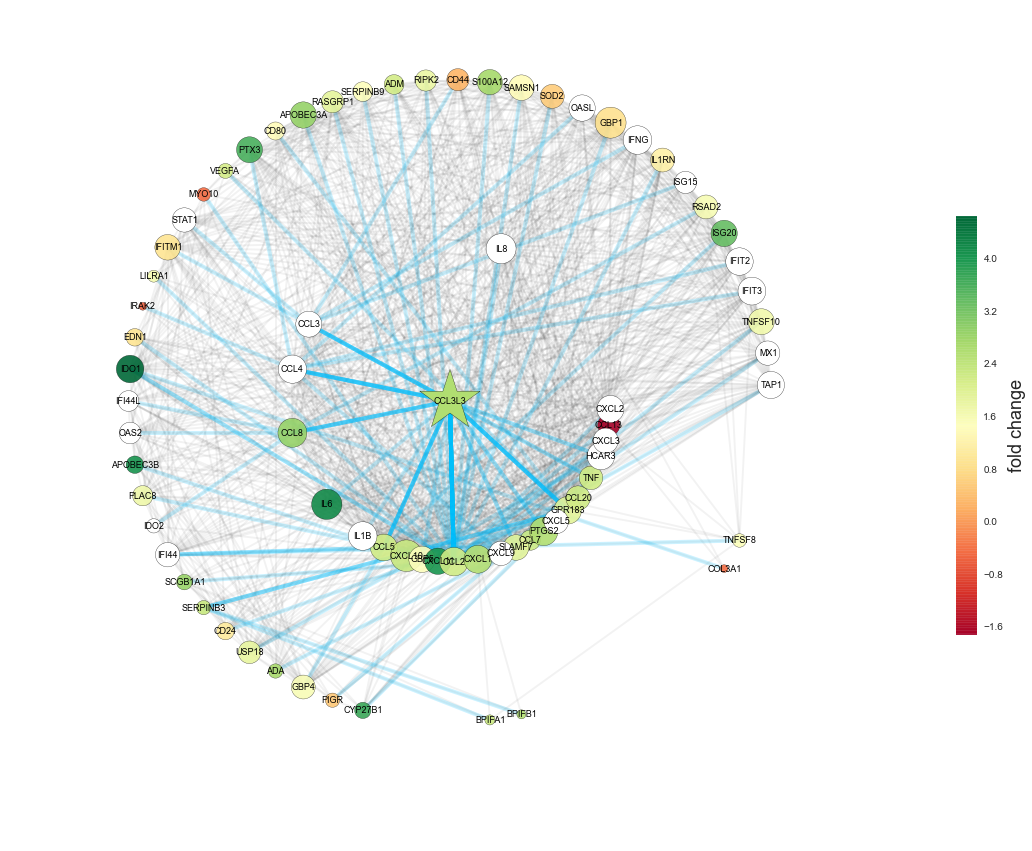

In [23]:
from IPython.html.widgets import interact
from IPython.html import widgets
import matplotlib.colorbar as cb
import seaborn as sns
import community

# import network plotting module
from plot_network import *

# temporary graph variable
Gtest = nx.Graph()

# check whether you have differential expression data
diff_exp_analysis=True

# replace G_DE_w with G_DE in these two lines if unweighted version is desired
Gtest.add_nodes_from(G_DE_w.nodes())  
Gtest.add_edges_from(G_DE_w.edges(data=True))

# prep border colors
nodes = Gtest.nodes()
#gene_list = gene_list

if diff_exp_analysis:
    diff_exp = dataDE_mean
    genes_intersect = np.intersect1d(gene_list,nodes)
    border_cols = Series(index=nodes)

    for i in genes_intersect:
        if diff_exp[i]=='Unmeasured':
            border_cols[i] = np.nan
        else:
            border_cols[i] = diff_exp[i] 
else:  # if no differential expression data
    border_cols = [None]


numnodes = len(Gtest)

# make these three global to feed into widget
global Gtest

global boder_cols  

global DE_network

def plot_network_shell(focal_node_name,edge_thresh=.5,network_algo='spl', map_degree=True,
                       plot_border_col=False, draw_shortest_paths=True,
                       coexpression=True, colocalization=True, other=False,physical_interactions=False,
                       predicted_interactions=False,shared_protein_domain=False):
    
    # this is the main plotting function, called from plot_network module
    fig = plot_network(Gtest, border_cols, DE_network,
                 focal_node_name, edge_thresh, network_algo, map_degree, plot_border_col, draw_shortest_paths,
                 coexpression, colocalization, other, physical_interactions, predicted_interactions, shared_protein_domain)


    return fig

# threshold slider parameters
min_thresh = np.min(DE_network['Weight'])
max_thresh = np.max(DE_network['Weight']/10)
thresh_step = (max_thresh-min_thresh)/1000.0

interact(plot_network_shell, focal_node_name=list(np.sort(nodes)),
         edge_thresh=widgets.FloatSliderWidget(min=min_thresh,max=max_thresh,step=thresh_step,value=min_thresh,description='edge threshold'),
         network_algo = ['community','clustering_coefficient','pagerank','spl']);


# Some examples

First let's look at the graph when 'spl' (shortest path length) is selected as the network algo.  ADA is the focal node in this case, and it has 4 nearest neighbors (MX1, CD44, FITM1, and CD80).  Note that CD44 connects the focal node ADA to many other nodes in the network, as it is an opaque blue line.  Also note that there is only one gene with a negative fold change in this gene set (CCL13).  The white nodes are genes included by genemania- they are the 20 genes nearest to the input genelist.

![shortest path length](screenshots/spl_ADA.png) 


## Community detection

When the network_algo button is switched to 'community', the louvain modularity maximization algorithm runs on the network, and partitions the nodes into communities which maximize the modularity.  In this case (with CXCL10 as the focal node), the nodes are partitioned into 5 groups, with the three largest groups indicated by red, green, and teal circles.  While you can see some support for this grouping by eye, the overall graph modularity is 0.33, which is a relatively low value.  This means that although groups were found in the graph, the graph itself is not very modular.  As a rule of thumb, very modular graphs have modularities of about 0.5 or 0.6.  

![shortest path length](screenshots/modularity_CXC10.png) 


Below the graph, there is a panel showing the average fold change for the nodes in this community.  Since most of the nodes in the input gene list have positive fold changes here, all communities also have positive average fold changes.  Were the input gene list to have fewer large fold changes, this would enable you to see if a particular grouping of nodes had significantly higher (or lower) levels of differential expression than alternative groupings.  

![shortest path length](screenshots/bar_plot_CXC10.png) 

{'ADA': (63.276, 212.91),
 'ADM': (179.29, 301.56),
 'APOBEC3A': (93.599, 259.19),
 'APOBEC3B': (258.71, 122.11),
 'BPIFA1': (55.328, 130.94),
 'BPIFB1': (125.99, 144.77),
 'CCL13': (260.46, 287.69),
 'CCL2': (245.68, 105.88),
 'CCL20': (313.14, 243.25),
 'CCL3': (248.17, 208.9),
 'CCL3L3': (220.89, 300.55),
 'CCL4': (138.4, 200.93),
 'CCL5': (145.12, 108.31),
 'CCL7': (340.48, 165.56),
 'CCL8': (132.89, 192.07),
 'CD24': (58.658, 199.78),
 'CD44': (304.43, 254.1),
 'CD80': (53.318, 172.51),
 'COL3A1': (193.17, 302.57),
 'CXCL1': (250.54, 110.86),
 'CXCL10': (181.11, 88.304),
 'CXCL11': (240.36, 101.4),
 'CXCL2': (247.71, 293.25),
 'CXCL3': (272.63, 280.93),
 'CXCL5': (327.24, 219.29),
 'CXCL9': (254.89, 116.29),
 'CYP27B1': (165.57, 18.0),
 'EDN1': (76.194, 237.52),
 'GBP1': (215.56, 89.136),
 'GBP4': (234.64, 97.446),
 'GBP5': (228.56, 94.065),
 'GPR183': (320.77, 231.61),
 'HCAR3': (284.08, 273.03),
 'IDO1': (167.89, 224.62),
 'IDO2': (165.57, 299.22),
 'IFI44': (267.89, 148.2),
 'I